In [1]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np

# Define folders
image_folder = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Dataset008_MDandAverageLVANDIPPrediction/imagesTr'
mask_folder = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Dataset008_MDandAverageLVANDIPPrediction/labelsTr'


# Loop through all image files
for image_file in os.listdir(image_folder):
    if image_file.endswith('.nii'):
        # Construct full paths for image and mask
        image_path = os.path.join(image_folder, image_file)
        # Match the corresponding mask file
        mask_file = image_file.replace('_image.nii', '_mask.nii')
        mask_path = os.path.join(mask_folder, mask_file)

        # Check if the mask exists
        if os.path.exists(mask_path):
            # Load the image and mask using nibabel
            image_nii = nib.load(image_path)
            mask_nii = nib.load(mask_path)

            # Get the data from the image and mask
            image_data = image_nii.get_fdata()
            mask_data = mask_nii.get_fdata()

            # Plot the image in grayscale
            plt.figure(figsize=(8, 8))
            plt.imshow(image_data, cmap='gray')

            # Overlay the mask where mask_data == 1
            mask_overlay = np.ma.masked_where(mask_data != 1, mask_data)
            plt.imshow(mask_overlay, cmap='Reds', alpha=0.5)  # Apply the mask with 50% opacity

            #plt.title(f'Overlay of {image_file}')
            plt.axis('off')
            plt.show()
        else:
            print(f'No matching mask found for {image_file}')



In [2]:
import os
import nibabel as nib

# Set the paths to your imagesTr and labelsTr directories
image_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/'
label_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/labelsTr/'

# Function to rename and save images with nibabel
def rename_and_compress_images(directory):
    for filename in os.listdir(directory):
        if 'slice' in filename and filename.endswith('.nii'):
            old_filepath = os.path.join(directory, filename)
            new_filename = filename.replace('_image.nii', '_0000.nii.gz')  # Add '_0000' before .nii.gz
            new_filepath = os.path.join(directory, new_filename)
            
            # Load the NIfTI file using nibabel
            img = nib.load(old_filepath)
            
            # Save it as compressed .nii.gz using nibabel
            nib.save(img, new_filepath)
            
            # Remove the old .nii file if it was successfully compressed
            os.remove(old_filepath)
            print(f'Renamed and compressed: {filename} -> {new_filename}')

# Function to rename and compress labels with nibabel
def rename_and_compress_labels(directory):
    for filename in os.listdir(directory):
        if 'slice' in filename and filename.endswith('.nii'):
            old_filepath = os.path.join(directory, filename)
            new_filename = filename.replace('_mask.nii', '.nii.gz')  # Remove '_mask' and compress
            new_filepath = os.path.join(directory, new_filename)
            
            # Load the NIfTI file using nibabel
            img = nib.load(old_filepath)
            
            # Save it as compressed .nii.gz using nibabel
            nib.save(img, new_filepath)
            
            # Remove the old .nii file if it was successfully compressed
            os.remove(old_filepath)
            print(f'Renamed and compressed: {filename} -> {new_filename}')

# Apply renaming and compressing to images and labels
rename_and_compress_images(image_dir)
rename_and_compress_labels(label_dir)


In [3]:
import os
import nibabel as nib

# Set the paths to your imagesTr and labelsTr directories
image_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/'
label_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/labelsTr/'

In [4]:
import os
import nibabel as nib

# Set the paths to your imagesTr and labelsTr directories
image_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/'
label_dir = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/labelsTr/'

# Function to check if .nii.gz files are correctly compressed
def check_nifti_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.nii.gz'):
            filepath = os.path.join(directory, filename)
            try:
                # Attempt to load the file using nibabel
                img = nib.load(filepath)
                print(f'File {filename} is valid.')
            except Exception as e:
                print(f'File {filename} is NOT valid. Error: {e}')

# Check the image and label directories
check_nifti_files(image_dir)
check_nifti_files(label_dir)


File Le_Volunteer_09_DiVO_12_05_slice_001_0000.nii.gz is NOT valid. Error: File /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/Le_Volunteer_09_DiVO_12_05_slice_001_0000.nii.gz is not a gzip file
File Le_Volunteer_11_DiVO_12_05_slice_002_0000.nii.gz is NOT valid. Error: File /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/Le_Volunteer_11_DiVO_12_05_slice_002_0000.nii.gz is not a gzip file
File Le_Volunteer_12_DiVO_10_06_slice_002_0000.nii.gz is NOT valid. Error: File /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNet/nnUNet_raw/Dataset002_CombinedLeDirectionsvsAverages/imagesTr/Le_Volunteer_12_DiVO_10_06_slice_002_0000.nii.gz is not a gzip file
File Le_Volunteer_03_DiVO_15_04_slice_003_0000.nii.gz is NOT valid. Error: File /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCro

In [5]:
#Tylers metrics.
def DICE(Seg_1, Seg_2):
    #from sklearn.metrics import jaccard_score
    #jac = jaccard_score(np.array(Segmentation_1), np.array(Segmentation_2))
    numerator   = np.sum((Seg_1 * Seg_2)) * 2
    denominator = np.sum(Seg_1) + np.sum(Seg_2)
    dice = numerator / denominator
    return dice

def hausdorff_distance(a_points, b_points):
    """Calculate the Hausdorff distance between nonzero elements of given images.
    The Hausdorff distance [1]_ is the maximum distance between any point on
    ``image0`` and its nearest point on ``image1``, and vice-versa.
    Parameters
    ----------
    image0, image1 : ndarray
        Arrays where ``True`` represents a point that is included in a
        set of points. Both arrays must have the same shape.
    Returns
    -------
    distance : float
        The Hausdorff distance between coordinates of nonzero pixels in
        ``image0`` and ``image1``, using the Euclidian distance.
    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Hausdorff_distance
    Examples
    --------
    >>> points_a = (3, 0)
    >>> points_b = (6, 0)
    >>> shape = (7, 1)
    >>> image_a = np.zeros(shape, dtype=bool)
    >>> image_b = np.zeros(shape, dtype=bool)
    >>> image_a[points_a] = True
    >>> image_b[points_b] = True
    >>> hausdorff_distance(image_a, image_b)
    3.0
    """
    from scipy.spatial import cKDTree
#     a_points = np.transpose(np.nonzero(image0))
#     b_points = np.transpose(np.nonzero(image1))

    # Handle empty sets properly:
    # - if both sets are empty, return zero
    # - if only one set is empty, return infinity
    if len(a_points) == 0:
        return 0 if len(b_points) == 0 else np.inf
    elif len(b_points) == 0:
        return np.inf

    return max(max(cKDTree(a_points).query(b_points, k=1)[0]),
               max(cKDTree(b_points).query(a_points, k=1)[0]))

def average_hausdorff_distance(a_points, b_points):
    from scipy.spatial import cKDTree
    test_1 = cKDTree(a_points).query(b_points, k=1)[0]
    test_2 = cKDTree(b_points).query(a_points, k=1)[0]
    AHD = ((1/len(a_points) * np.sum(test_1)) + (1/len(b_points) * np.sum(test_2))) / 2
    return AHD

In [155]:
#WORKIGN 
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import center_of_mass

# Hausdorff distance function
def hausdorff_distance(a_points, b_points):

    #if no IP's are detected by nnUnet -> failsave, return distance 1000 
    if np.any(np.isnan(a_points)) or np.any(np.isinf(a_points)) or \
    np.any(np.isnan(b_points)) or np.any(np.isinf(b_points)):
        return 1000 
    if len(a_points) == 0:
        return 0 if len(b_points) == 0 else np.inf
    elif len(b_points) == 0:
        return np.inf
    return max(max(cKDTree(a_points).query(b_points, k=1)[0]),
               max(cKDTree(b_points).query(a_points, k=1)[0]))

# Average Hausdorff distance function
def average_hausdorff_distance(a_points, b_points):
    test_1 = cKDTree(a_points).query(b_points, k=1)[0]
    test_2 = cKDTree(b_points).query(a_points, k=1)[0]
    AHD = ((1/len(a_points) * np.sum(test_1)) + (1/len(b_points) * np.sum(test_2))) / 2
    return AHD

# Calculate center of mass (centroid) of a mask label
def calculate_center_of_mass(mask, label_value):
    return center_of_mass(mask == label_value)

# Load NIfTI files for the masks and original images, including the affine matrix
def load_nifti_with_affine(file_path):
    nifti_file = nib.load(file_path)
    return nifti_file.get_fdata(), nifti_file.affine

# Convert pixel distances to real-world distances using voxel spacing
def convert_to_physical_distance(pixel_distance, spacing):
    return pixel_distance * spacing

def calculate_all_points(mask, label_value):
    points = np.argwhere(mask == label_value)
    return points 



In [156]:
def calculate_scale_factor(original_affine, crop_mask_path, target_size=256):
    # Load crop mask to determine the crop region dimensions in the original image
    crop_mask, _ = load_nifti_with_affine(crop_mask_path)

    # Since each pixel represents 1mm in the x and y directions
    original_spacing = np.array([1.0, 1.0])

    # Identify the bounding box of the region where the mask equals 1
    coords = np.array(np.where(crop_mask == 1))
    min_coords = coords.min(axis=1)
    max_coords = coords.max(axis=1)
    print(f' min and max coords: {min_coords} and {max_coords}')

    # Calculate the side lengths of the crop region in pixels
    crop_width = max_coords[0] - min_coords[0] + 1
    crop_height = max_coords[1] - min_coords[1] + 1

    print(f'cropwidth and hight: {crop_width}, {crop_height}')
    # Calculate scaling factors for x and y axes from the original crop region to 256x256
    scale_x = crop_width / target_size
    scale_y = crop_height / target_size

    # Use the average scale for isotropic assumption in Hausdorff calculation
    average_scale = (scale_x + scale_y) / 2
    return average_scale

In [157]:
from scipy.ndimage import zoom

def upscale_segmentation_to_original(segmentation, crop_mask_path, target_size=256):
    # Load the crop mask to determine the original crop dimensions
    crop_mask, _ = load_nifti_with_affine(crop_mask_path)
    
    # Identify the bounding box of the region where the mask equals 1
    coords = np.array(np.where(crop_mask == 1))
    min_coords = coords.min(axis=1)
    max_coords = coords.max(axis=1)

    # Calculate the width and height of the crop region in the original image
    crop_width = max_coords[0] - min_coords[0] + 1
    crop_height = max_coords[1] - min_coords[1] + 1

    # Calculate the scale factors for interpolation
    scale_x = crop_width / target_size
    scale_y = crop_height / target_size

    # Perform the interpolation (upscale) on the segmentation label
    # Use nearest-neighbor interpolation to maintain discrete label values
    upscaled_segmentation = zoom(segmentation, (scale_x, scale_y), order=0)  # order=0 for nearest-neighbor

    # Place the upscaled segmentation back into the original crop position
    # Create an empty mask with the original image size
    full_size_mask = np.zeros_like(crop_mask)

    # Insert the upscaled segmentation into the crop location in the original size mask
    full_size_mask[min_coords[0]:min_coords[0]+upscaled_segmentation.shape[0], 
                   min_coords[1]:min_coords[1]+upscaled_segmentation.shape[1]] = upscaled_segmentation

    return full_size_mask


In [158]:
def evaluate_hausdorff_and_plot(pred_mask, gt_mask, original_image, scale_factor, filename):
    # Calculate center points for labels in upscaled masks
    pred_center_2 = calculate_center_of_mass(pred_mask, 2)
    gt_center_2 = calculate_center_of_mass(gt_mask, 2)
    pred_center_3 = calculate_center_of_mass(pred_mask, 3)
    gt_center_3 = calculate_center_of_mass(gt_mask, 3)

    # Calculate Hausdorff distances in pixel units
    hausdorff_2 = hausdorff_distance([pred_center_2], [gt_center_2])
    avg_hausdorff_2 = average_hausdorff_distance([pred_center_2], [gt_center_2])
    hausdorff_3 = hausdorff_distance([pred_center_3], [gt_center_3])
    avg_hausdorff_3 = average_hausdorff_distance([pred_center_3], [gt_center_3])

    # Convert to real-world distances using the scale factor
    hausdorff_2_physical = convert_to_physical_distance(hausdorff_2, scale_factor)
    avg_hausdorff_2_physical = convert_to_physical_distance(avg_hausdorff_2, scale_factor)
    hausdorff_3_physical = convert_to_physical_distance(hausdorff_3, scale_factor)
    avg_hausdorff_3_physical = convert_to_physical_distance(avg_hausdorff_3, scale_factor)

    # Print out Hausdorff results to confirm calculations
    print(f"Filename: {filename}")
    print(f"Hausdorff 2 (pixels): {hausdorff_2}, (mm): {hausdorff_2_physical}")
    print(f"Avg Hausdorff 2 (pixels): {avg_hausdorff_2}, (mm): {avg_hausdorff_2_physical}")
    print(f"Hausdorff 3 (pixels): {hausdorff_3}, (mm): {hausdorff_3_physical}")
    print(f"Avg Hausdorff 3 (pixels): {avg_hausdorff_3}, (mm): {avg_hausdorff_3_physical}")

    # Plot everything for visual inspection

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_masks_and_hausdorff(original_image, pred_mask, gt_mask, pred_center_2, gt_center_2, pred_center_3, gt_center_3, filename):
    plt.figure(figsize=(8, 8))
    #plt.title(f"Overlay of Downsampled Original Image and Masks: {filename}")
    
    # Display the original image
    plt.imshow(original_image, cmap='gray')
    
    # Define custom colormaps for prediction and ground truth masks
    # Prediction mask colormap: [Background, LV, Label 2, Label 3]
    pred_colors = [
        (0, 0, 0, 0),          # 0 - Transparent
         (0, 1, 1, 0.5),       # 1 - Cyan   
        (0, 0, 1, 0.5),        # 2 - Blue (Label 2)
        (0, 0, 1, 0.5),        # 3 - Blue (Label 3)
    ]
    pred_cmap = ListedColormap(pred_colors)
    
    # Ground truth mask colormap: [Background, LV, Label 2, Label 3]
    gt_colors = [
        (0, 0, 0, 0),          # 0 - Transparent
        (1, 1, 0, 0.5),         # 1 - Yellow
        (1, 0, 0, 0.5),        # 2 - Red (Label 2)
        (1, 0, 0, 0.5)         # 3 - Red (Label 3)
    ]
    gt_cmap = ListedColormap(gt_colors)
    
    # Overlay ground truth mask
    plt.imshow(gt_mask, cmap=gt_cmap, interpolation='none',label = 'GT LV Mask' )
    
    # Overlay prediction mask
    plt.imshow(pred_mask, cmap=pred_cmap, interpolation='none',label = 'Pred LV Mask')
    
    # Plot center points and Hausdorff lines for label 2
    plt.scatter(*pred_center_2[::-1], color='blue', label='Prediction Center 2', marker='x', s=100)
    plt.scatter(*gt_center_2[::-1], color='red', label='Ground Truth Center 2', marker='+', s=100)
    plt.plot([pred_center_2[1], gt_center_2[1]], [pred_center_2[0], gt_center_2[0]], 'b--', label='Hausdorff Distance 2')
    
    # Plot center points and Hausdorff lines for label 3
    plt.scatter(*pred_center_3[::-1], color='blue', label='Prediction Center 3', marker='x', s=100)
    plt.scatter(*gt_center_3[::-1], color='red', label='Ground Truth Center 3', marker='+', s=100)
    plt.plot([pred_center_3[1], gt_center_3[1]], [pred_center_3[0], gt_center_3[0]], 'm--', label='Hausdorff Distance 3')
    
    #plt.legend(loc='upper right')
    plt.axis('off')
    plt.show()



In [159]:
import sys
sys.path.append('/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024/Distortion_Correction_Data')
from cardpy.Tools.Contours import Myocardial_Mask_Contour_Extraction

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import pandas as pd

def plot_original_with_masks(original_image, upscaled_pred_mask, upscaled_gt_mask, scale_factor, filename):
    """
    Plots the original image with overlaid upscaled prediction and ground truth masks, 
    and visualizes the Hausdorff distance between the mask center points.
    """
    # Calculate center points for labels 2 and 3
    pred_center_2 = calculate_center_of_mass(upscaled_pred_mask, 2)
    gt_center_2 = calculate_center_of_mass(upscaled_gt_mask, 2)
    pred_center_3 = calculate_center_of_mass(upscaled_pred_mask, 3)
    gt_center_3 = calculate_center_of_mass(upscaled_gt_mask, 3)

    # Calculate Hausdorff distances for label 2 and label 3
    hausdorff_2 = hausdorff_distance([pred_center_2], [gt_center_2])
    hausdorff_3 = hausdorff_distance([pred_center_3], [gt_center_3])

    # Convert pixel distances to real-world distances using the scale factor
    hausdorff_2_physical = hausdorff_2 * scale_factor
    hausdorff_3_physical = hausdorff_3 * scale_factor

    # Define custom colormaps for prediction and ground truth masks
    # Prediction mask colormap: [Background, LV, Label 2, Label 3]
    pred_colors = [
        (0, 0, 0, 0),          # 0 - Transparent
         (0, 1, 1, 0.5),       # 1 - Cyan   
        (0, 0, 1, 0.5),        # 2 - Blue (Label 2)
        (0, 0, 1, 0.5),        # 3 - Blue (Label 3)
    ]
    pred_cmap = ListedColormap(pred_colors)
    
    # Ground truth mask colormap: [Background, LV, Label 2, Label 3]
    gt_colors = [
        (0, 0, 0, 0),          # 0 - Transparent
        (1, 1, 0, 0.5),         # 1 - Yellow
        (1, 0, 0, 0.5),        # 2 - Red (Label 2)
        (1, 0, 0, 0.5)         # 3 - Red (Label 3)
    ]
    gt_cmap = ListedColormap(gt_colors)

    # Plot original image
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image, cmap='gray')

    # Overlay ground truth mask
    plt.imshow(upscaled_gt_mask, cmap=gt_cmap, interpolation='none')

    # Overlay prediction mask
    plt.imshow(upscaled_pred_mask, cmap=pred_cmap, interpolation='none')

    # Plot center points and Hausdorff lines for label 2
    plt.scatter(*pred_center_2[::-1], color='blue', marker='x', s=100, label='Prediction center of mass ')
    plt.scatter(*gt_center_2[::-1], color='red', marker='+', s=100, label='GT center of mass ')
    plt.plot([pred_center_2[1], gt_center_2[1]], [pred_center_2[0], gt_center_2[0]], 'b--', 
             label=f'HD superior IP [mm]')

    # Plot center points and Hausdorff lines for label 3
    #plt.scatter(*pred_center_3[::-1], color='blue', marker='x', s=100, label='Prediction inferior 3')
    #plt.scatter(*gt_center_3[::-1], color='red', marker='+', s=100, label='GT inferior ')
    plt.plot([pred_center_3[1], gt_center_3[1]], [pred_center_3[0], gt_center_3[0]], 'm--', 
             label=f'HD inferior IP [mm]')

    # Create legend handles for the GT masks
    gt_patches = [
        Patch(facecolor=gt_colors[1], edgecolor='none', label='GT LV Mask '),
        ,
        #Patch(facecolor=gt_colors[3], edgecolor='none', label='GT Inferior ')
    ]

    # Create legend handles for the Prediction masks
    pred_patches = [
        Patch(facecolor=pred_colors[1], edgecolor='none', label='Pred LV Mask '),
        Patch(facecolor=gt_colors[2], edgecolor='none', label='GT Insertion Point'),
        Patch(facecolor=pred_colors[2], edgecolor='none', label='Pred Insertion Point '),
       #Patch(facecolor=pred_colors[3], edgecolor='none', label='Pred Inferior ')
    ]

    # Get existing handles and labels from the plot
    handles, labels = plt.gca().get_legend_handles_labels()

    # Combine all handles
    all_handles = gt_patches + pred_patches + handles

    # Display legend and remove axes
    #plt.legend(handles=all_handles, loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.axis('off')
    plt.show()

    fig_legend = plt.figure(figsize=(8, 6))
    ax_legend = fig_legend.add_subplot(111)
    ax_legend.axis('off')

    # Add the legend to the new figure
    legend = ax_legend.legend(handles=all_handles, loc='center', frameon=False)

    # Adjust layout and show the legend figure
    plt.tight_layout()
    plt.show()


SyntaxError: invalid syntax (2039239813.py, line 70)

In [192]:
def evaluate_hausdorff_downsampled(pred_file, gt_file, scale_factor, original_image, filename):
    # Load the downsampled prediction and ground truth masks
    print(f'pred_file : {pred_file}')
    pred_mask, _ = load_nifti_with_affine(pred_file)

    gt_mask, _ = load_nifti_with_affine(gt_file)
    
    binary_pred_mask = (pred_mask == 1).astype(np.uint8)
    binary_gt_mask   = (gt_mask == 1).astype(np.uint8)
    if binary_pred_mask.ndim == 2:
        binary_pred_mask = binary_pred_mask[:, :, np.newaxis]
    if binary_gt_mask.ndim == 2:
        binary_gt_mask = binary_gt_mask[:, :, np.newaxis]

    print(f'shape of binary pred masks: {np.shape(binary_gt_mask)}')
 





    
    # Calculate center points for downsampled masks
    pred_center_2 = calculate_center_of_mass(pred_mask, 2)
    gt_center_2 = calculate_center_of_mass(gt_mask, 2)
    pred_center_3 = calculate_center_of_mass(pred_mask, 3)
    gt_center_3 = calculate_center_of_mass(gt_mask, 3)
    
    # Hausdorff distance in pixels for downsampled mask
    hausdorff_2_pixels = hausdorff_distance([pred_center_2], [gt_center_2])
    hausdorff_3_pixels = hausdorff_distance([pred_center_3], [gt_center_3])
    
    # Convert pixel distances to physical distances using scale_factor
    hausdorff_2_mm = hausdorff_2_pixels * scale_factor
    hausdorff_3_mm = hausdorff_3_pixels * scale_factor
    
    # Debug output for downsampled
    
    print(f"Downsampled Hausdorff distance for label 2 (pixels): {hausdorff_2_pixels}")
    print(f"Downsampled Hausdorff distance for label 2 (mm): {hausdorff_2_mm}")
    print(f"Downsampled Hausdorff distance for label 3 (pixels): {hausdorff_3_pixels}")
    print(f"Downsampled Hausdorff distance for label 3 (mm): {hausdorff_3_mm}")
    
    # **Ensure the original image matches the mask dimensions**
    if original_image.shape != pred_mask.shape:
        from skimage.transform import resize
        original_image_resized = resize(original_image, pred_mask.shape, preserve_range=True, anti_aliasing=True)
    else:
        original_image_resized = original_image
    
    # Plot downsampled masks with original image for visual validation
    plot_masks_and_hausdorff(original_image_resized, pred_mask, gt_mask, pred_center_2, gt_center_2, pred_center_3, gt_center_3, filename)
    
    return {
        
        "Hausdorff_2 (pixels)": hausdorff_2_pixels,
        "Hausdorff_2 (mm)": hausdorff_2_mm,
        "Hausdorff_3 (pixels)": hausdorff_3_pixels,
        "Hausdorff_3 (mm)": hausdorff_3_mm,
    }


def evaluate_hausdorff_original(original_pred_mask, original_gt_mask, original_image, filename):


    binary_pred_mask = (original_pred_mask == 1).astype(np.uint8)
    binary_gt_mask   = (original_gt_mask == 1).astype(np.uint8)
    if binary_pred_mask.ndim == 2:
        binary_pred_mask = binary_pred_mask[:, :, np.newaxis]
    if binary_gt_mask.ndim == 2:
        binary_gt_mask = binary_gt_mask[:, :, np.newaxis]

    # Calculate center points for original masks
    pred_center_2 = calculate_center_of_mass(original_pred_mask, 2)
    gt_center_2 = calculate_center_of_mass(original_gt_mask, 2)
    pred_center_3 = calculate_center_of_mass(original_pred_mask, 3)
    gt_center_3 = calculate_center_of_mass(original_gt_mask, 3)
    
    # Hausdorff distance in pixels for original mask (pixels correspond to mm)
    hausdorff_2_pixels = hausdorff_distance([pred_center_2], [gt_center_2])
    hausdorff_3_pixels = hausdorff_distance([pred_center_3], [gt_center_3])
    


    epicardium_contours_pred, endocardium_contours_pred, endocardial_centers_pred = Myocardial_Mask_Contour_Extraction(binary_pred_mask,0)
    epicardium_contours_gt, endocardium_contours_gt, endocardial_centers_gt = Myocardial_Mask_Contour_Extraction(binary_gt_mask,0)
    print(f'shape of epi pred masks: {np.shape(epicardium_contours_gt)}')
    print(f'epi shape pred: {np.shape(epicardium_contours_pred)},epi contour gt shape:{ np.shape( epicardium_contours_gt)}')
    # Transpose and assign back to variables
    ##Shape to 256x256x1
    epicardium_contours_gt = np.transpose(epicardium_contours_gt, (1, 2, 0))
    epicardium_contours_pred = np.transpose(epicardium_contours_pred, (1, 2, 0))
    endocardium_contours_pred = np.transpose(endocardium_contours_pred, (1, 2, 0))
    endocardium_contours_gt = np.transpose(endocardium_contours_gt, (1, 2, 0))
    # Print shapes after transpose
    print(f'shapes after transpose: epi shape pred: {np.shape(epicardium_contours_pred)}, epi contour gt shape: {np.shape(epicardium_contours_gt)}')

    # Plot

    plt.figure(figsize=(15, 10))

    # First row: Ground Truth Masks (Binary, Epicardium, Endocardium)
    plt.subplot(2, 4, 1)
    plt.imshow(binary_gt_mask, cmap='gray')
    plt.title("Binary GT Mask")

    plt.subplot(2, 4, 2)
    plt.imshow(epicardium_contours_gt[:, :, 0], cmap='gray')
    plt.title("Epicardium GT")

    plt.subplot(2, 4, 3)
    plt.imshow(endocardium_contours_gt[:, :, 0], cmap='gray')
    plt.title("Endocardium GT")

    # Second row: Prediction Masks (Binary, Epicardium, Endocardium)
    plt.subplot(2, 4, 5)
    plt.imshow(binary_pred_mask, cmap='gray')
    plt.title("Binary Pred Mask")

    plt.subplot(2, 4, 6)
    plt.imshow(epicardium_contours_pred[:, :, 0], cmap='gray')
    plt.title("Epicardium Pred")

    plt.subplot(2, 4, 7)
    plt.imshow(endocardium_contours_pred[:, :, 0], cmap='gray')
    plt.title("Endocardium Pred")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    avg_hausdorff_epi = average_hausdorff_distance(epicardium_contours_pred[:,:,0], epicardium_contours_gt[:,:,0])
    avg_hausdorff_endo = average_hausdorff_distance(endocardium_contours_pred[:,:,0], endocardium_contours_gt[:,:,0])
    #avg_hausdorff_endocardial = average_hausdorff_distance(endocardial_centers_pred, endocardial_centers_gt)

    print(f'Average HD on LV in (mm): {avg_hausdorff_epi}')
    # Debug output for original
    print(f"original Hausdorff distance for label 2 (pixels/mm): {hausdorff_2_pixels}")
    print(f"original Hausdorff distance for label 3 (pixels/mm): {hausdorff_3_pixels}")
    
    # Plot original image with original masks and Hausdorff distance for validation
    plot_original_with_masks(original_image, original_pred_mask, original_gt_mask, scale_factor=1.0, filename=filename)
    
    return {
        "Hausdorff_2 (pixels/mm)": hausdorff_2_pixels,
        "Hausdorff_3 (pixels/mm)": hausdorff_3_pixels,
        "Avg. HD endo": avg_hausdorff_endo,
        "Avg. HD epi": avg_hausdorff_epi,
    }


In [193]:
# Create a separate figure for the legend



In [ ]:
def dice_score_original(gt_mask, pred_mask, label=1):
    """
    Calculate the Dice score on the GT and prediction masks for label 1 (left ventricle).
    """
    gt = (gt_mask == label)
    pred = (pred_mask == label)
    intersection = np.logical_and(gt, pred).sum()
    gt_sum = gt.sum()
    pred_sum = pred.sum()
    dice = (2. * intersection) / (gt_sum + pred_sum) if (gt_sum + pred_sum) > 0 else 1
    return dice

def histogram_comparison(gt_mask, pred_mask, original_image, label=1):
    """
    Compare histograms of label 1 from gt_mask and pred_mask based on the intensities
    in the segmented area in the original_image. Plots a comparison view and calculates
    a mean percentage difference.
    """
    gt_mask_label = (gt_mask == label)
    pred_mask_label = (pred_mask == label)
    
    gt_intensities = original_image[gt_mask_label]
    pred_intensities = original_image[pred_mask_label]
    
    # Plot histograms with custom colors
    plt.figure()
    plt.hist(gt_intensities.ravel(), bins=50, alpha=0.5, color='blue', label='Ground Truth')
    plt.hist(pred_intensities.ravel(), bins=50, alpha=0.5, color='red', label='Prediction')
    plt.legend()
    plt.title(f'Intensity Histogram Comparison for Label {label}')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()
    # Calculate mean intensities
    gt_mean_intensity = gt_intensities.mean()
    pred_mean_intensity = pred_intensities.mean()
    
    # Mean percentage difference
    if gt_mean_intensity != 0:
        mean_percentage_difference = abs(gt_mean_intensity - pred_mean_intensity) / gt_mean_intensity * 100
    else:
        mean_percentage_difference = 0.0  # Avoid division by zero
    
    print(f"Mean intensity - Ground Truth: {gt_mean_intensity}")
    print(f"Mean intensity - Prediction: {pred_mean_intensity}")
    print(f"Mean percentage difference: {mean_percentage_difference:.2f}%")
    
    return mean_percentage_difference


Processing Le_Volunteer_04_DiVO_15_04_slice_002.nii.gz...
 min and max coords: [17 45] and [106 134]
cropwidth and hight: 90, 90
downsampled image name : /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024/Le/Volunteer_04/Distortion_Corrected/DiVO_15_04/05_Segmentation_Images_CI/Cropped_Average_Diffusion_Weighted_Image_Slice_002.nii
pred_file : /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNetResults/Run11/Le_Volunteer_04_DiVO_15_04_slice_002.nii.gz
shape of binary pred masks: (256, 256, 1)
Downsampled Hausdorff distance for label 2 (pixels): 1.2689477813192156
Downsampled Hausdorff distance for label 2 (mm): 0.4461144543700367
Downsampled Hausdorff distance for label 3 (pixels): 3.679248751666542
Downsampled Hausdorff distance for label 3 (mm): 1.2934858892577688


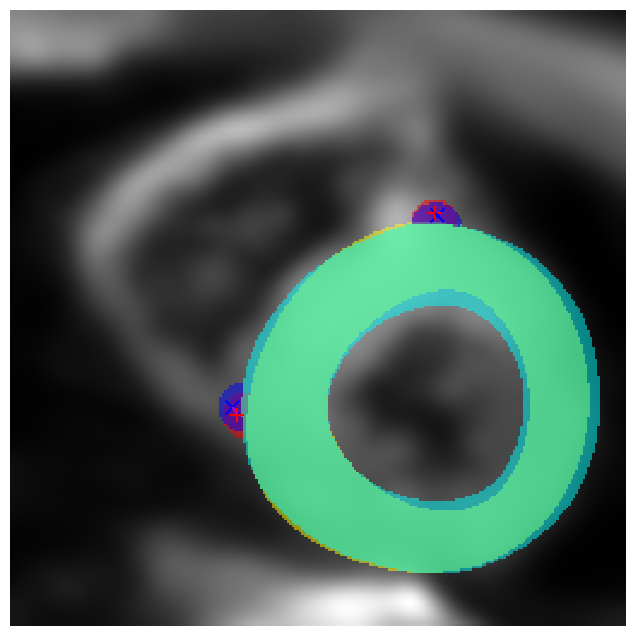

Downsampled Evaluation: {'Hausdorff_2 (pixels)': 1.2689477813192156, 'Hausdorff_2 (mm)': 0.4461144543700367, 'Hausdorff_3 (pixels)': 3.679248751666542, 'Hausdorff_3 (mm)': 1.2934858892577688}
original prediction and ground truth masks.
Saved original masks:
 - Prediction: /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024/Le/Volunteer_04/Distortion_Corrected/DiVO_15_04/01_Original_Images/upsampled_pred_Slice002.nii.gz
 - Ground truth: /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024/Le/Volunteer_04/Distortion_Corrected/DiVO_15_04/01_Original_Images/upsampled_gt_Slice_002.nii.gz
shape of epi pred masks: (1, 200, 200)
epi shape pred: (1, 200, 200),epi contour gt shape:(1, 200, 200)
shapes after transpose: epi shape pred: (200, 200, 1), epi contour gt shape: (200, 200, 1)


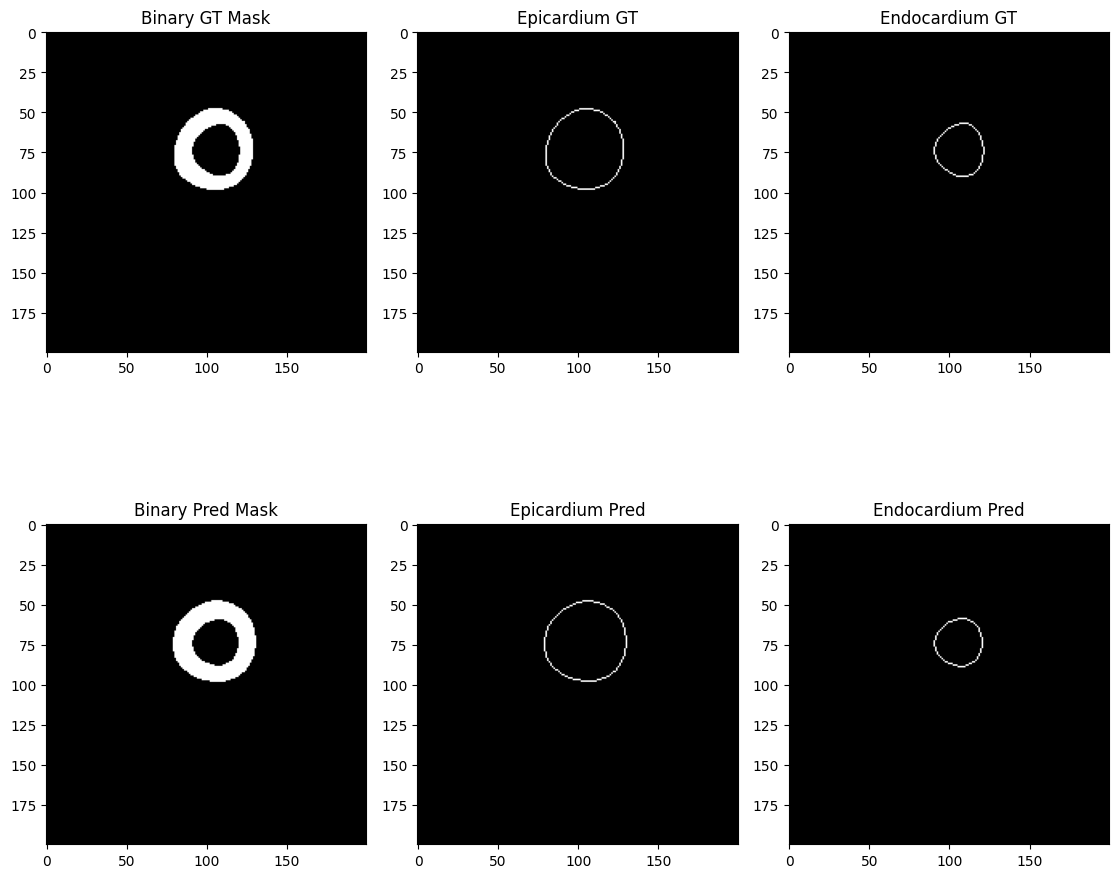

Average HD on LV in (mm): 0.264364907091156
original Hausdorff distance for label 2 (pixels/mm): 0.5376453291901642
original Hausdorff distance for label 3 (pixels/mm): 1.661111111111108


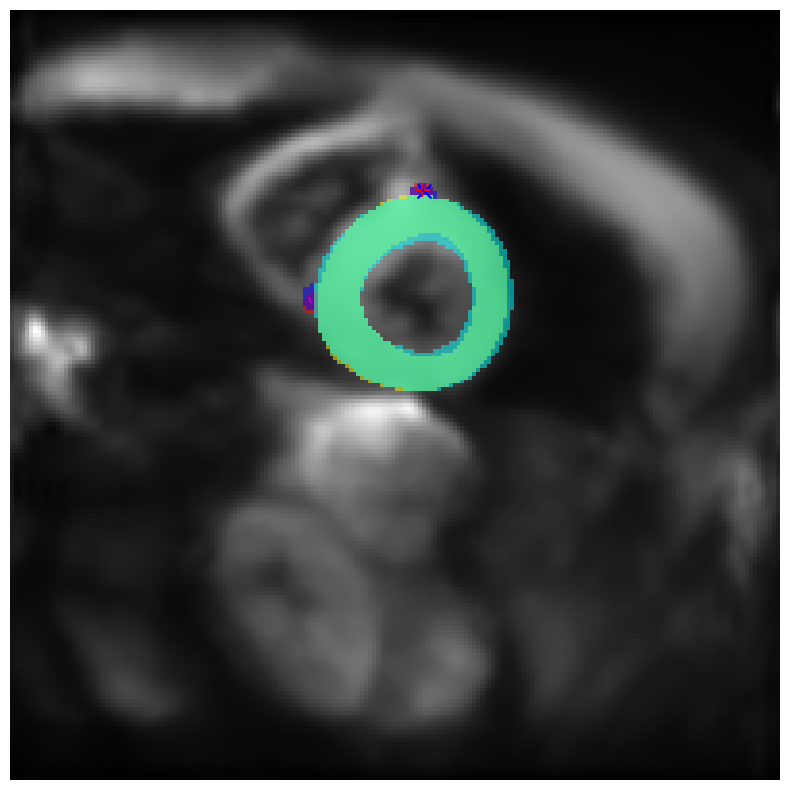

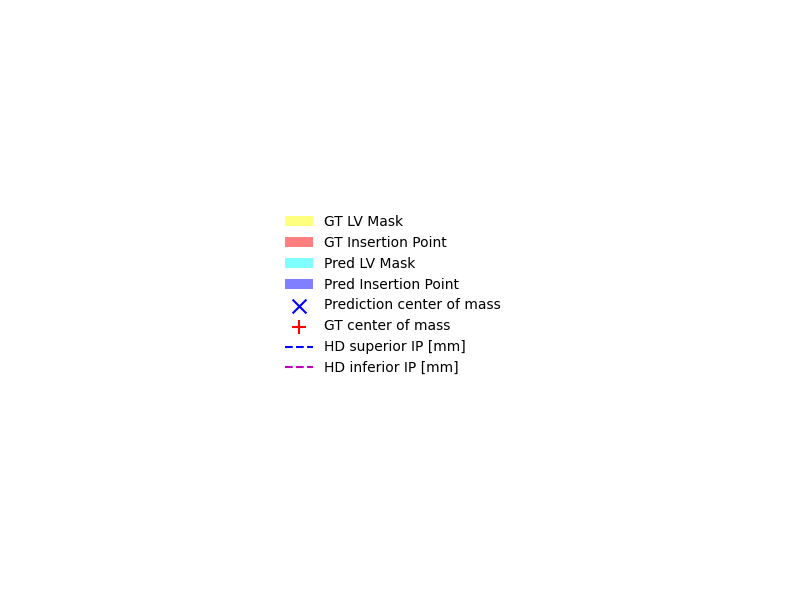

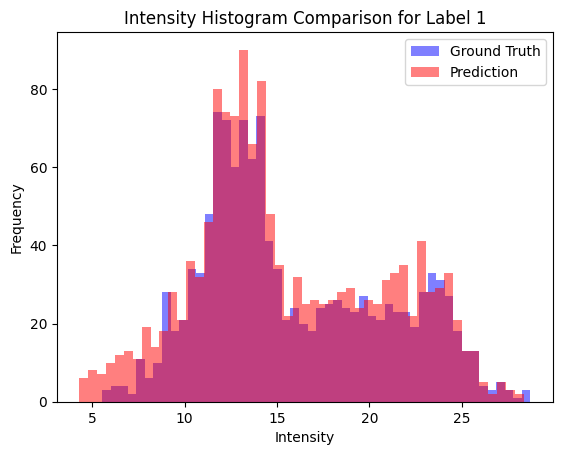

Mean intensity - Ground Truth: 15.910896593709815
Mean intensity - Prediction: 15.57313031813952
Mean percentage difference: 2.12%
Mean percentage difference in intensities for label 1: 2.12%
Comparing physical distances for label 2:
Downsampled Hausdorff distance (mm): 0.4461144543700367
original Hausdorff distance (mm): 0.5376453291901642
Difference: 0.09153087482012745


In [ ]:
metrics_data=[]
def process_folders(pred_folder, gt_folder, main_folder):
    #

    for pred_file in os.listdir(pred_folder):
        if pred_file.endswith('.nii.gz'):
            pred_path = os.path.join(pred_folder, pred_file)
            gt_path = os.path.join(gt_folder, pred_file)
            
            if os.path.exists(gt_path):
                print(f"Processing {pred_file}...")

                # For later, csv file generation/join with nnUnet output
                case_id = pred_file.replace('.nii.gz','')
                  # e.g., '002'

                parts = pred_file.split('_')
                volunteer_id = f"{parts[1]}_{parts[2]}"
                divo_folder = f"{parts[3]}_{parts[4]}_{parts[5]}"
                slice_name = parts[-1].replace('.nii.gz', '.nii')  # Adjust for .nii extension
                slice_number = parts[-1].replace('.nii.gz', '') 
                # Construct paths to the original image slice and crop mask
                original_image_path = os.path.join(
                    main_folder,
                    parts[0], volunteer_id, 'Distortion_Corrected', divo_folder, 
                    '03_Segmentation_Images', 'Average_Diffusion_Weighted_Image_Slice_' + slice_name
                )
                crop_mask_path = os.path.join(
                    main_folder,
                    parts[0], volunteer_id, 'Distortion_Corrected', divo_folder,
                    '02_Crop_Masks', 'Square_Crop_Mask_Slice_' + slice_name
                )
                downsampled_original_image_path = os.path.join(
                    main_folder,
                    parts[0], volunteer_id, 'Distortion_Corrected', divo_folder,
                    '05_Segmentation_Images_CI', 'Cropped_Average_Diffusion_Weighted_Image_Slice_' + slice_name
                )

                if os.path.exists(original_image_path) and os.path.exists(crop_mask_path):
                    # Load the original image
                    original_image, original_affine = load_nifti_with_affine(original_image_path)
                    
                    # Calculate scale factor
                    scale_factor = calculate_scale_factor(original_affine, crop_mask_path)
                    
                    # Load downsampled prediction and ground truth masks
                    # These are already at 256x256
                    pred_mask, _ = load_nifti_with_affine(pred_path)
                    gt_mask, _ = load_nifti_with_affine(gt_path)
                    downsampled_original_image, _ = load_nifti_with_affine(downsampled_original_image_path)

                    print(f'downsampled image name : {downsampled_original_image_path}')
                    # Evaluate downsampled masks
                    results_downsampled = evaluate_hausdorff_downsampled(pred_path, gt_path, scale_factor, downsampled_original_image,pred_file)
                    print("Downsampled Evaluation:", results_downsampled)
                    
                    # Upscale masks to original dimensions
                    original_pred_mask = upscale_segmentation_to_original(pred_mask, crop_mask_path)
                    original_gt_mask = upscale_segmentation_to_original(gt_mask, crop_mask_path)
                    print("original prediction and ground truth masks.")

                    # Save original masks (optional)
                    original_pred_path = os.path.join(main_folder, parts[0], volunteer_id, 'Distortion_Corrected', divo_folder,
                                                      '01_Original_Images', f'upsampled_pred_Slice{slice_number}.nii.gz')
                    original_gt_path = os.path.join(main_folder, parts[0], volunteer_id, 'Distortion_Corrected', divo_folder,
                                                    '01_Original_Images', f'upsampled_gt_Slice_{slice_number}.nii.gz')

                    nib.save(nib.Nifti1Image(original_pred_mask, original_affine), original_pred_path)
                    nib.save(nib.Nifti1Image(original_gt_mask, original_affine), original_gt_path)
                    print(f"Saved original masks:\n - Prediction: {original_pred_path}\n - Ground truth: {original_gt_path}")
                    
                    # Evaluate original masks
                    results_original = evaluate_hausdorff_original(original_pred_mask, original_gt_mask, original_image, pred_file)
                    hausdorff_distance_label2 = results_original.get('Hausdorff_2 (pixels/mm)', np.nan)
                    hausdorff_distance_label3 = results_original.get('Hausdorff_3 (pixels/mm)', np.nan)
                    avg_hausdorff_epi= results_original.get('Avg. HD epi',np.nan)
                    avg_hausdorff_endo= results_original.get('Avg. HD endo',np.nan)
                    

                    
                    
                    dice_original_1= dice_score_original(original_gt_mask, original_pred_mask, label=1)
                    dice_original_2= dice_score_original(original_gt_mask, original_pred_mask, label=2)
                    dice_original_3= dice_score_original(original_gt_mask, original_pred_mask, label=2)

                    # Compare histograms of intensities in the segmented areas
                    mean_percentage_difference = histogram_comparison(original_gt_mask, original_pred_mask, original_image, label=1)
                    print(f"Mean percentage difference in intensities for label 1: {mean_percentage_difference:.2f}%")
                    # Compare the physical distances
                    print("Comparing physical distances for label 2:")
                    print(f"Downsampled Hausdorff distance (mm): {results_downsampled['Hausdorff_2 (mm)']}")
                    print(f"original Hausdorff distance (mm): {results_original['Hausdorff_2 (pixels/mm)']}")
                    print(f"Difference: {abs(results_downsampled['Hausdorff_2 (mm)'] - results_original['Hausdorff_2 (pixels/mm)'])}")
                    # Similar comparison for label 3
                    metrics_entry = {
                        'Case ID': case_id,
                        'Slice Number': slice_number,
                        'Dice Score Original Label 1': dice_original_1,
                        'Dice Score Original Label 2': dice_original_2,
                        'Dice Score Original Label 3': dice_original_3,
                        'Hausdorff Distance Label 2': hausdorff_distance_label2,
                        'Hausdorff Distance Label 3': hausdorff_distance_label3,
                        'Mean Percentage Difference Label 1': mean_percentage_difference,
                        'Avg. HD Epi': avg_hausdorff_epi,
                        'Avg. HD Endo': avg_hausdorff_endo,
                    }
                    metrics_data.append(metrics_entry)
                else:
                    print(f"Original or crop mask not found for {pred_file}. Expected paths:\n - Original: {original_image_path}\n - Crop Mask: {crop_mask_path}")
            else:
                print(f"No ground truth found for {pred_file}, skipping.")

            
            

pred_folder = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNetResults/Run11'
gt_folder = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024/Directions_vs_Averages_Data/Dataset011_LVandIPspredicitoxandycombinedLVFix/labelsTr'
main_folder = '/Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/Summer_of_Segmentation_2024'  # Root folder containing subdirectories for each volunteer
process_folders(pred_folder, gt_folder, main_folder)




In [190]:
#Making json file into csv:


import json
import pandas as pd

json_path = f'{pred_folder}/summary.json'

# Load the JSON data
with open(json_path, 'r') as f:
    data = json.load(f)
# Initialize lists to hold the data
case_ids = []
labels = []
dice_scores = []

# Iterate over each case in 'metric_per_case'
for case_index, case in enumerate(data['metric_per_case']):
    # You can extract a case ID from the file name or use the index
    prediction_file = case['prediction_file']
    case_id = prediction_file.split('/')[-1]  # Get the file name as case ID
    # Remove file extension if needed
    case_id = case_id.replace('.nii.gz', '')
    
    metrics = case['metrics']
    for label, metric_values in metrics.items():
        dice = metric_values['Dice']
        case_ids.append(case_id)
        labels.append(f'Label {label}')
        dice_scores.append(dice)

# Create a DataFrame
df = pd.DataFrame({
    'Case ID': case_ids,
    'Label': labels,
    'Dice Score': dice_scores
})

# Save the DataFrame to a CSV file
csv_file_path = f'{pred_folder}/dice_scores_per_case.csv'
df.to_csv(csv_file_path, index=False)

print(f'Data saved to {csv_file_path}')


Data saved to /Users/saschastocker/Documents/Stanford/work2024/WholeHeartCropISMRM/nnUNetResults/Run11/dice_scores_per_case.csv


In [179]:
# After processing all cases, create a DataFrame from the collected metrics
new_metrics_df = pd.DataFrame(metrics_data)

# Read the existing CSV file
existing_csv_path = f'{pred_folder}/dice_scores_per_case.csv'
existing_df = pd.read_csv(existing_csv_path)

# Ensure 'Case ID' is a string and strip whitespace
existing_df['Case ID'] = existing_df['Case ID'].astype(str).str.strip()
new_metrics_df['Case ID'] = new_metrics_df['Case ID'].astype(str).str.strip()

# Print the 'Case ID' columns to verify they match
print('############################################')
print('DF fusion')
print('Existing DF Case IDs:')
print(existing_df['Case ID'])
print('New Metrics DF Case IDs:')
print(new_metrics_df['Case ID'])
print('############################################')

# Merge the new metrics into the existing DataFrame
combined_df = pd.merge(existing_df, new_metrics_df, on='Case ID', how='left')



# Save the combined DataFrame back to the CSV file
combined_df.to_csv(existing_csv_path, index=False)
print(f'Updated metrics data saved to {existing_csv_path}')

############################################
DF fusion
Existing DF Case IDs:
0      Le_Volunteer_01_DiVO_06_10_slice_002
1      Le_Volunteer_01_DiVO_06_10_slice_002
2      Le_Volunteer_01_DiVO_06_10_slice_002
3      Le_Volunteer_01_DiVO_12_05_slice_002
4      Le_Volunteer_01_DiVO_12_05_slice_002
                       ...                 
121    Le_Volunteer_12_DiVO_12_05_slice_001
122    Le_Volunteer_12_DiVO_12_05_slice_001
123    Le_Volunteer_12_DiVO_15_04_slice_002
124    Le_Volunteer_12_DiVO_15_04_slice_002
125    Le_Volunteer_12_DiVO_15_04_slice_002
Name: Case ID, Length: 126, dtype: object
New Metrics DF Case IDs:
0     Le_Volunteer_04_DiVO_15_04_slice_002
1     Le_Volunteer_06_DiVO_15_04_slice_001
2     Le_Volunteer_12_DiVO_15_04_slice_002
3     Le_Volunteer_11_DiVO_12_05_slice_003
4     Le_Volunteer_10_DiVO_30_02_slice_003
5     Le_Volunteer_08_DiVO_12_05_slice_001
6     Le_Volunteer_06_DiVO_10_06_slice_002
7     Le_Volunteer_03_DiVO_20_03_slice_003
8     Le_Volunteer_09_DiVO_3